Imports

In [1]:
#pip install ipywidgets==7.7 jupyterlab

In [2]:
import ipympl
import scipy.io
import numpy as np
import csv    
import scipy.io
import matplotlib.pyplot as plt
import statistics
import math
import sklearn
from sklearn import svm
from sklearn.metrics import hinge_loss
import csv
from matplotlib.ticker import ScalarFormatter
from sklearn.multiclass import OutputCodeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification
import math
from mpl_toolkits.mplot3d import Axes3D

%matplotlib widget

Open Dataset

In [3]:
# open the file
# name of the data key happens to be the name of the file

mat_data = scipy.io.loadmat('dosing_rr_and_ataxia_data_nnet.mat')

# key into the actual dataset
mat_data = mat_data['dosing_rr_and_ataxia_data']

open_original_data

Opens X.csv, consisting of a matrix of [standard_deviation, walk1, walk2]
Opens Y.csv, consisting of corresponding predictors for X
Opens BinaryY.csv, consisting of a 10 column matrix with 0, 1, -1, corresponding whether a learner places a datapoint into a positive or negative class (or ignores)

Returns a matrix where the X datapoints are sorted by ataxia score [0, 1, 2, 3, 4] and what each learner does with a datapoint (like 1, -1, 0)
Of the format [[standard_deviation, walk1, walk2], [0,1,2, etc (of length 10)]]

In [4]:
def open_original_data():
    # x matrix -- in the format of [standard_deviation, walk1, walk2]
    x = []
    with open('X.csv', mode ='r')as file:
      csvFile = csv.reader(file)
      for lines in csvFile:
        # split the CSV file
        new = lines[0].split(',')
        # fun things to turn the string into floats
        for entry in range(len(new)):
            new[entry] = float(new[entry])
        x.append(new)        
    
    # y matrix, correlating with the ataxia score
    y = []
    with open('Y.csv', mode ='r')as file:
      csvFile = csv.reader(file)
      for lines in csvFile:
        new = lines[0].split(',')
        for entry in range(len(new)):
            new[entry] = float(new[entry])
        y += (new)

    learnerY = []
    with open('BinaryY.csv', mode ='r') as file:
      csvFile = csv.reader(file)
      for lines in csvFile:
        ro = []
        # split the CSV file
        #new = lines.split(',')
        # fun things to turn the string into floats
        for entry in range(len(lines)):
            ro.append(float(lines[entry]))
        learnerY.append(ro)
    
    
    original_data = [[], [], [], [], []]
    for value in range(len(y)):
        try:
            if int(y[value]) in range(0, len(original_data)):
                original_data[int(y[value])].append([x[value], learnerY[value]])
        except:
            pass

    return original_data


bl

This file really isn't used besides in a quick cross comparison of the slopes of the hyperplanes via the Matlab learners and the Python learners

Opens binary_learners_linear.csv, returning the x, y, and z components of the slope for the hyperplane and bias (of form (slope_x * x + slope_y * y + slope_z * z + bias = 0)


In [5]:
def bl():
    slope = []
    bias =[]
    
    with open('binary_learners_linear.csv', mode ='r') as file:
      csvFile = csv.reader(file)
      for lines in csvFile:
        # split the CSV file to extract the slopes
        for entry in range(len(lines)):
            lines[entry] = float(lines[entry])
            if len(slope) != 10:
                slope.append([lines[entry]])
            else:
                slope[entry].append(lines[entry])
                
    # snipping out the bias and adding it to its own list
    for row in slope:
        bias.append(row[3])
        row.pop(3)

    # reformatting
    temp_slope = []
    temp_bias = []
    
    for ind in range(len(slope)):
        temp_slope.append(slope[ind])
        temp_bias.append(bias[ind])

    slope = temp_slope
    bias = temp_bias
       
    return slope, bias

cm

Opens coding_matrix, which consists of rows consisting of 10 columns, corresponding to the 10 learners. There are 5 rows, corresponding to the ataxia score. For a given learner, if the scoring is in the positive category, add it to that list, if negative, add to the 'other' list. This function simply returns the list version of the csv file.


In [6]:
def cm():
    coding_matrix = []

    with open('coding_matrix.csv', mode ='r') as file:
        csvFile = csv.reader(file)
        for lines in csvFile:
            new_line = []
            # split the CSV file
            # fun things to turn the string into floats
            for entry in range(len(lines)):
                lines[entry] = float(lines[entry])
                new_line.append(lines[entry])
            coding_matrix.append(new_line)
    return coding_matrix

mbl

Input is the output from open_original_data, where the data is sorted based off of ataxia score. 
The data is transformed based on whether or not learners count a point, and if they go to the positive or negative group, corresponding to the binary comparisons of each learner (ex is it 0 or 1)

For the returned list, only 2 lists within mod_by_learner should be filled, corresponding to the two ataxia scores being compared in the visuals below

In [7]:
def mbl():
    mod_by_learner = [[], [], [], [], []]
    
    # iterate through ataxia scores
    for ataxia in range(len(mod_by_learner)):
        # is the point actually being counted per the coding_matrix/big_lst (not 0)
        if big_lst[learner][ataxia] != 0:
            # iterating through the 100 datapoints categorized by ataxia score
            for row in ori[ataxia]:
                new_y = row[0]

                # positive group
                if big_lst[learner][ataxia] == 1:
                    mod_by_learner[ataxia].append(row[0])

                # negative group, need to find the positive group identity and put the value in there
                # need to figure out this new part
                elif big_lst[learner][ataxia] == -1:
                    mod_by_learner[ataxia].append(row[0])
                    new_ind = [big_lst[learner][m] for m in range(len(mod_by_learner))]
                    ind = new_ind.index(-1)

                else:
                    pass
    return mod_by_learner

In [8]:
slope, bias = bl()

plot_mod

With input from mbl, the points are plotted for two ataxia scores. In addition, the hyperplanes from both the Matlab and Python programs are superimposed on the graph.

In [9]:
def plot_mod():
    # initialize 3D figure
    fig = plt.figure()
    ax = plt.axes(projection ='3d')

    # color coding
    characteristics = [['red', 'zero'], ['orange', 'one'], ['yellow', 'two'], ['green', 'three'], \
                       ['blue', 'four']]
    
    # initialize string for main title
    title = ''
    boundary = [[], [], []]

    # find both datasets and plot them
    for ataxia in range(len(mod_by_learner)):
        ax.scatter([mod_by_learner[ataxia][x][0] for x in range(len(mod_by_learner[ataxia]))], \
                     [mod_by_learner[ataxia][x][1] for x in range(len(mod_by_learner[ataxia]))],\
                  [mod_by_learner[ataxia][x][2] for x in range(len(mod_by_learner[ataxia]))], \
                     characteristics[ataxia][0], label = characteristics[ataxia][1])

        # find boundaries for the hyperplane plotting
        # max and min x, y, and z
        if mod_by_learner[ataxia] != []:
            # only add to the title if actually depicted
            title += (characteristics[ataxia][1] + " vs ")
            
            for indexx in range(3):
                # find appropriate x y boundaries for hyperplane
                max11 = round(max([mod_by_learner[ataxia][x][indexx] for x in \
                                                       range(len(mod_by_learner[ataxia]))])) + 4
                min11 = round(min([mod_by_learner[ataxia][x][indexx] for x in \
                                                       range(len(mod_by_learner[ataxia]))])) - 4
                if boundary[indexx] == []:
                    boundary[indexx].append(max11) 
                    boundary[indexx].append(min11)
                # max out the mins and max for x and y
                else:
                    if boundary[indexx][0] < max11:
                        boundary[indexx][0] = max11
                    if boundary[indexx][1] > min11:
                        boundary[indexx][1] = min11
            
    projections_mat = []
    projections_pyth = []

    # use these inputs to solve for z
    xx, yy = np.meshgrid(range(boundary[0][1], boundary[0][0], ((abs(boundary[0][1]) + \
                abs(boundary[0][0]))//5 + 1)), range(boundary[1][1], boundary[1][0], \
                ((abs(boundary[1][1]) + abs(boundary[1][0]))//5 + 1)))

    # iterate through, solve for z using the formula (slope_x * x + slope_y * y + slope_z * z + bias = 0)
    for rowx in range(len(xx)):
        new_row_1 = []
        new_row_2 = []
        for x_1 in range(len(xx[rowx])):
            # coefficients, bias from Matlab model
            new_row_1.append( - bias[learner]/ slope[learner][2] - \
                             slope[learner][0] * xx[rowx][x_1]/slope[learner][2] - \
                                slope[learner][1] * yy[rowx][x_1]/slope[learner][2])
        
        
            # coefficients, intercept from the Python model
            new_row_2.append( -intercept / coefficients[2] - \
                             coefficients[1]* yy[rowx][x_1]/coefficients[2] - \
                             coefficients[0] * xx[rowx][x_1]/coefficients[2])

        projections_mat.append(new_row_1)
        projections_pyth.append(new_row_2)
    
    projections_mat  = np.array(projections_mat)
    projections_pyth  = np.array(projections_pyth)


    # new -- make Python and Matlab lines
    ax.plot_surface(xx, yy, projections_mat, color = 'pink', alpha=0.3)
    ax.plot_surface(xx, yy, projections_pyth, color = 'black', alpha=0.3)

    title = title[: - 4]

    
    plt.legend()
    plt.title(title)
    plt.show()

    fig.savefig('output_picture/' + title + '_image.png')



join

Small function, just takes x, makes a list, then makes a y list based on the mod_by_learner location, corresponding to the ataxia score

In [10]:
# taking in input, seeing predictions and tuning...
def join():
    x = []
    y = []
    
    for input in range(len(mod_by_learner)):
        for category in mod_by_learner[input]:
            x.append(category)
            y.append(input)
    return x, y

Aggregate -- function calls

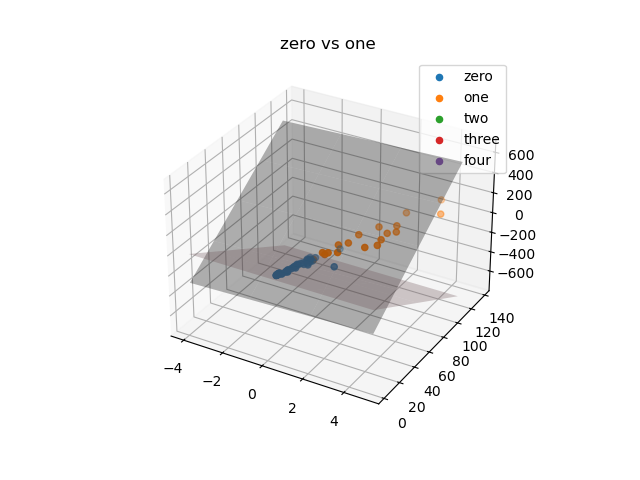

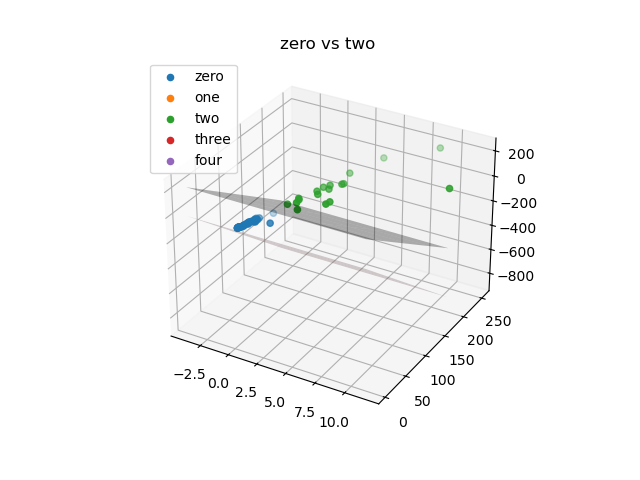

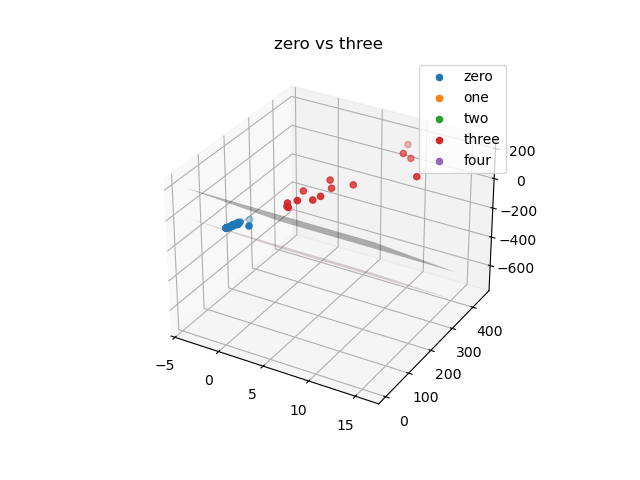

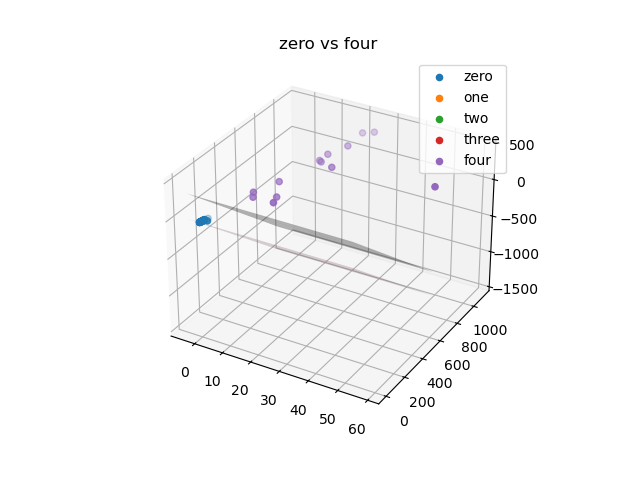

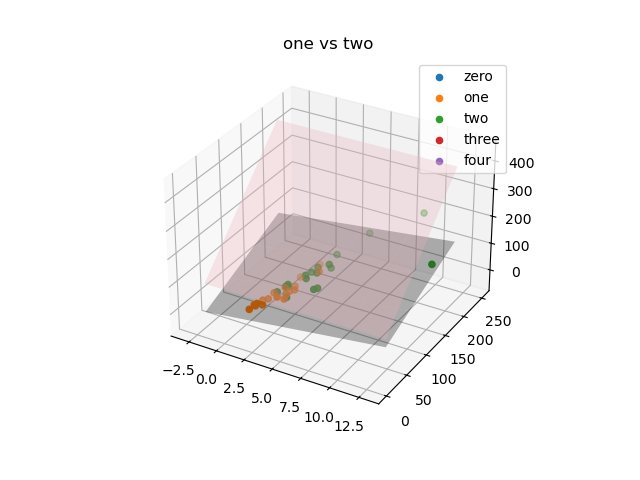

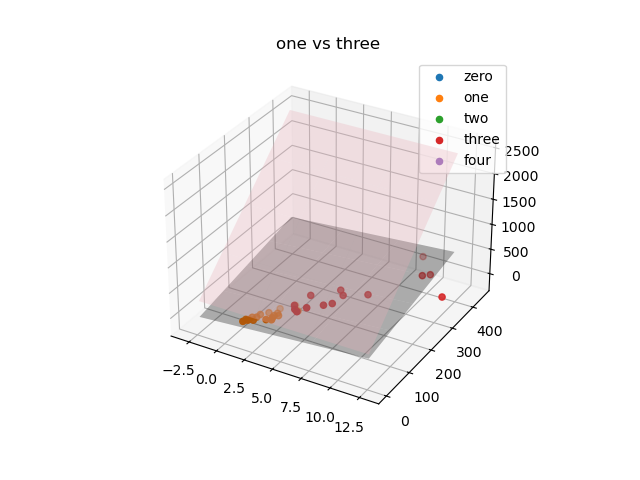

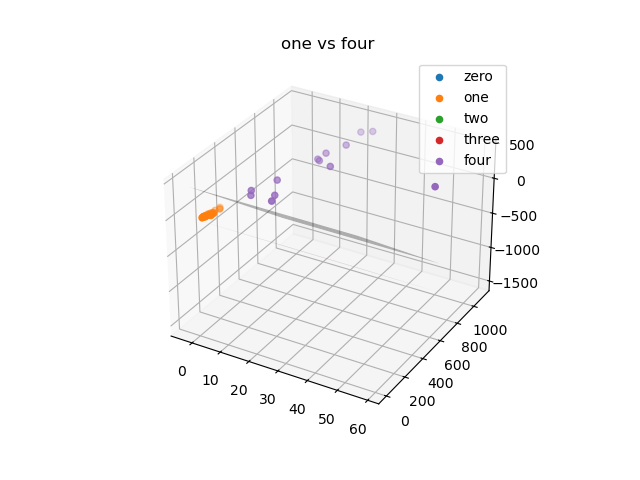

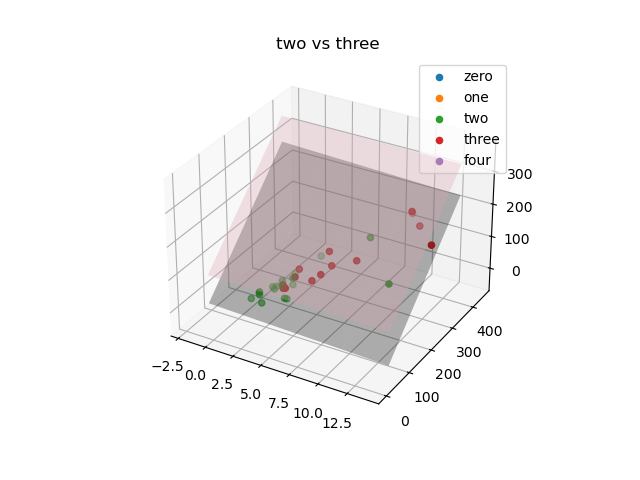

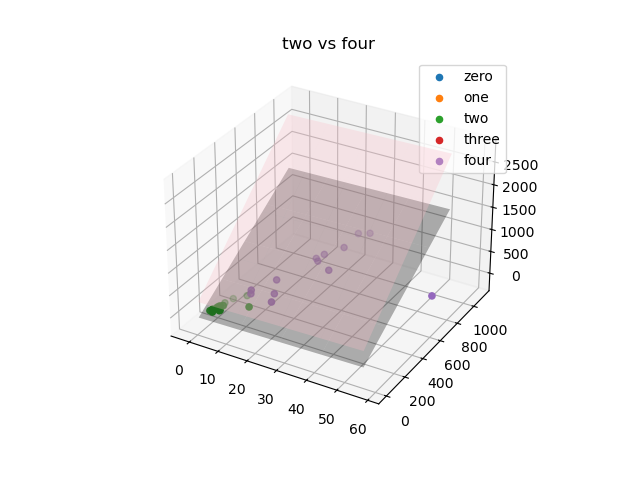

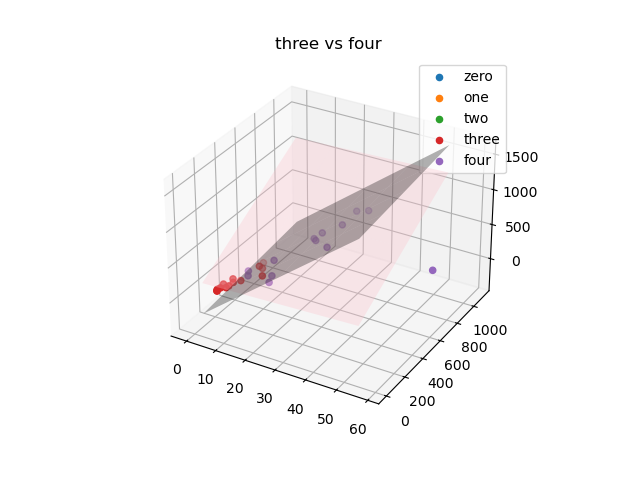

In [11]:
# open x and y
ori = open_original_data()

# open coding_matrix (what ataxia score comparisons does each learner make)
coding_matrix = cm()

# just reformatting of coding_matrix
big_lst = [[], [], [], [], [], [], [], [], [], []]
for learn in coding_matrix:
    for l in range(len(big_lst)):
        big_lst[l].append(learn[l])

# all of the learners
clf1 = svm.SVC(kernel = 'linear', gamma = 28, decision_function_shape = 'ovo')
clf2 = svm.SVC(kernel = 'linear', gamma = 28, decision_function_shape = 'ovo')
clf3 = svm.SVC(kernel = 'linear', gamma = 28, decision_function_shape = 'ovo')
clf4 = svm.SVC(kernel = 'linear', gamma = 28, decision_function_shape = 'ovo')
clf5 = svm.SVC(kernel = 'linear', gamma = 28, decision_function_shape = 'ovo')
clf6 = svm.SVC(kernel = 'linear', gamma = 28, decision_function_shape = 'ovo')
clf7 = svm.SVC(kernel = 'linear', gamma = 28, decision_function_shape = 'ovo')
clf8 = svm.SVC(kernel = 'linear', gamma = 28, decision_function_shape = 'ovo')
clf9 = svm.SVC(kernel = 'linear', gamma = 28, decision_function_shape = 'ovo')
clf10 = svm.SVC(kernel = 'linear', gamma = 28, decision_function_shape = 'ovo')


biiig = [clf1, clf2, clf3, clf4, clf5, clf6, clf7, clf8, clf9, clf10]

# extracting the coefficients and bias
big_coefficients = []
big_intercepts = []

# for large aggregate show of data at bottom cell
group_by_ataxia = [[], [], [], [], []]

# for each comparison, one image per 
for learner in range(len(big_lst)):
    mod_by_learner = mbl()
    x, y = join()

    # reshaping all data for plot at bottom cell
    for lear in range(len(mod_by_learner)):
        if mod_by_learner[lear] != [] and group_by_ataxia[lear] == []:
            group_by_ataxia[lear] = mod_by_learner[lear]

    # train each model
    model = biiig[learner].fit(x, y)

    # extract hyperplane characteristics
    coefficients = model.coef_[0]
    big_coefficients.append(coefficients)
    intercept = model.intercept_[0]
    big_intercepts.append(intercept)

    # plot it
    plot_mod()

ataxia2

The final product is a graph. First, plot the raw data per patient. Second, produce the data [standard_deviation, step1, step2] from the raw data for prediction models. For the predictions, run through all 10 learners, produce ataxia scores for each data point, choose the most popular ataxia score for an input. Plot the ataxia scores against the raw data

In [12]:
def ataxia2():
    
    # loc is sifted by which patient (1 - 26 in this dataset) 
    # mat_data[number_pt][0] is to get past a list shell
    loc = mat_data[number_pt][0]
    
    # number of significant events corresponds to the number of rows
    # significant events = based on the number of rows in a datafile, corresponds
    # with dosing scheduling, where different breathing events were noted
    lst = []
    # add together a giant list of all of the events (of the format [time, 
    # breathing interval])
    for sig_event in range(len(loc)):
        arr = loc[sig_event][0]
        list1 = arr.tolist()
        lst += list1
    local = np.array(lst)

    # x_graph and y_graph plot the raw data of the entire experiment
    # the time needs normalized to minutes from 100 Hz
    x_graph = [row[0]/6000 for row in local]
    # corresponding respiratory interval
    y_graph = [row[1] for row in local]

    # plot the raw patient data
    fig, ax1 = plt.subplots()
    ax1.set_title('Patient ' + str(number_pt + 1))
    ax2 = ax1.twinx()
    ax1.semilogy(x_graph, y_graph)
    ax1.set_xlabel('time (minutes)', color = 'blue')

    ax1.set_yscale('linear')
    ax1.locator_params(integer=True)
    ax1.set_ylim(-0.5, max(y_graph) + 1)
    ax1.set_ylabel('Breath interval (s)', color= 'blue')


    # iterating through significant event timepoints to make 
    # predictions within a period of time (periods of time are broken up by change
    # in breathing pattern

    # for excel output
    all_times = []
    all_predictions = []
    
    for sig_event in range(len(loc)):

        # location indexes in to list of format [breath_mark, breath_interval]
        location = loc[sig_event][3]
        
        #1st element of column, corresponding to breath mark
        lst = [row[0] for row in location]
        
        # 'walking' requirement of at least 30 breaths to be able to approximate breathing trends
        if len(lst) > 30:
            features = []

            # obtain all the breath marks that are <30 breaths from the end, stepping up by one 
            # position each time
            # Rationale: steady state is reached when the breath mark is started, want to obtain the
            # best prediction by staying 30 breaths away from the end
            for a in range(len(lst) - 29):

                # take 30 breaths
                b_index = lst[a:a + 30]
                temp = np.array(b_index)
                # find difference in breath mark times (size of matrix = 29, 1 less than temp)
                tbbs = np.diff(temp)

                # find standard deviation of the difference of breath mark times
                st = statistics.stdev(tbbs)/100

                # squaring all the differences (tbbs) in the list
                # x corresponding to differences (tbbs) minus last entry
                x = list(map(lambda m: m / 100, tbbs[:28]))
                new_x = list(map(lambda m: m ** 2, np.diff(x)))

                # squaring all the differences (tbbs) in the list
                # y corresponding to differences (tbbs) minus first entry
                y = list(map(lambda m: m / 100, tbbs[1:]))
                new_y = list(map(lambda m: m ** 2, np.diff(y)))

                #I assume x and y are to cut out the edge effects

                # add the squares of adjacent breath marks then find square root
                new_lst = [new_x[i] + new_y[i] for i in range(len(new_x))]   
                walk = list(map(lambda m: m ** (1/2), new_lst))

                num = 0
                for elem in walk:
                    num += elem

                # onto the second walk
                walk2 = 0

                # take off 5 more entries from the end of x
                for w in range(len(x) - 5):

                    # like new_x and new_y, just 5 element lists
                    new_x_2 = list(map(lambda m: m ** 2, np.diff(x[w: w + 6])))
                    new_y_2 = list(map(lambda m: m ** 2, np.diff(y[w: w + 6])))
                    new_lst_2 = [new_x_2[i] + new_y_2[i] for i in range(len(new_x_2))]   
                    # same pattern of adding x and y (squared), finding root of sum
                    walk2_temp = list(map(lambda m: m ** (1/2), new_lst_2))
                    
                    num2 = 0
                    # once again, Python did not want to just add stuff?
                    for elem2 in walk2_temp:
                        num2 += elem2
        
                    if num2 > walk2:
                        walk2 = num2
        
                # once standard deviation and two walks are calculated, appended to a final 
                # list which will predict the ataxia score based on the model trained above
                # [standard deviation, sum of walk of len(list) - 30, sum of walk of first 5 elements]
                # same format as x of ML model, used to predict ataxia scoring
                features.append([st, num, walk2])

            # this part summarizes what the decision of a comparison is (aka what ataxia score a 
            # point gets); the actual learner that is used is which is closest to the boundary line/
            # hyperplane

            # the ataxia score
            big_decision = []
            
            for mod in range(10):
                guesss = biiig[mod].predict(features)
                guessstemp = guesss.tolist()
                if big_decision == []:
                    for objec in guessstemp:
                        big_decision.append([objec])
                else:
                    for objec in range(len(guessstemp)):
                        big_decision[objec].append(guessstemp[objec])

            # the main part of the ECOC, choose the ataxia score that is the most popular (mode)
            # across the learners
            final_decision = []
            for eleme in big_decision:
                final_decision.append(statistics.mode(eleme))


            # check how close it is to the real data
            # equivalence of dosing_rr_and_ataxia_data{i}{ii,4}(30:end,1)/6000
            # this finds the period of time (x axis) that was sampled
            new_x = [location[29 + i][0]/6000 for i in range(len(location[29:]))]
        
            # plot the ataxia predictions superimposed on the data
            ax2.plot(new_x, final_decision, color = 'red')
            ax2.locator_params(integer=True)
            ax2.set_ylim(-0.5, 4.5)
            ax2.set_ylabel('Ataxia score', color= 'red')
        
            # save image
            fig.savefig('output_picture/' + str(number_pt) + '_image.png')

            all_times.append(new_x)
            all_predictions.append(final_decision)
    return all_times, all_predictions


maximize_ataxia

for all patients extract the maximums across the significant events, as well as value at end, and maximum overall

In [45]:
def maximize_ataxia(ex):
    # set up header
    final_final = [['Patient number', 'End value', 'Maximum overall', \
                    'Maximum across significant events']]
    #iterate through all patients
    for patient in range(len(ex)):
        # some idiosyncrasies with formatting depending on the number of prediction sets
        if len(ex[patient][1]) > 1:
            # patient identifier, last prediction value (wrt time)
            new_row_1 = [patient + 1, ex[patient][1][: - 1][-1][-1]]
            maxes = []
            for sig_events_1 in ex[patient][1]:
                maxes.append(max(sig_events_1))
            # maximum overall
            new_row_1.append(max(maxes))
            # maximum with each significant event
            new_row_1 += maxes
        elif len(ex[patient][1]) == 1:
            new_row_1 = [patient + 1, ex[patient][1][-1][-1]] + [max(ex[patient][1][-1]), \
                                                                 max(ex[patient][1][-1])]
        else:
            new_row_1 = [patient + 1, None, None, None]

        final_final.append(new_row_1)

    with open('ataxia_predictions.csv', 'w', newline='') as f:
        writer = csv.writer(f)
        writer.writerows(final_final)

classify

For bookkeeping -- comparing coefficients from the hyperplanes in Python and Matlab. Not required.

In [14]:
slope, bias = bl()

def classify():
    # alterative comparison
    # open up right slope and bias

    for model in range(len(biiig)):
        print("Trained")
        print(biiig[model].coef_[0])
        print(biiig[model].intercept_[0])
        print("Matlab coefficients")
        print(slope[model])
        print(bias[model])
        
classify()

Trained
[ 0.16694113  0.20226512 -0.02673178]
-7.788686173463385
Matlab coefficients
[-0.012815074, -1.818549605, -0.301149245]
3.275382021
Trained
[0.00609182 0.0921431  0.02812264]
-6.482397452582363
Matlab coefficients
[-0.056807687, -1.262618459, -0.304251985]
2.832230476
Trained
[0.00090513 0.02414113 0.0124817 ]
-2.5313967538010744
Matlab coefficients
[-0.025343755, -0.67595174, -0.349487722]
2.53139688
Trained
[0.00042312 0.00656703 0.00412718]
-1.430582355051171
Matlab coefficients
[-0.011853983, -0.183842358, -0.115610501]
1.43049552
Trained
[ 0.46380845  0.07763689 -0.0946931 ]
-5.146740855532512
Matlab coefficients
[-0.057880499, -1.122529034, 0.511529028]
3.312885151
Trained
[ 1.361854    0.10401393 -0.08507543]
-12.610396123013997
Matlab coefficients
[-0.077182389, -1.293528873, 0.215637518]
5.173855259
Trained
[0.00092874 0.01056011 0.00660952]
-2.908036058349986
Matlab coefficients
[-0.026004676, -0.295682886, -0.185066587]
2.908035861
Trained
[-0.04278866  0.03858357 -0

Aggregate -- where the code actually runs from

In [47]:
# start feeding actual functions
#for excel sheet to export

excel_export = []

for number_pt in range(len(mat_data)):
    time_interest, predictions = ataxia2()
    excel_export.append([time_interest, predictions])

# produce an excel sheet for comparison
print(maximize_ataxia(excel_export))

None


Plot of all the data

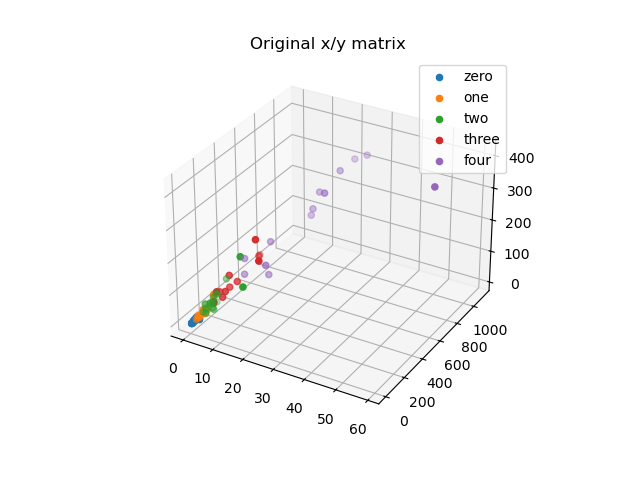

In [46]:
# plot data
fig = plt.figure()
ax = plt.axes(projection ='3d')

characteristics = [['red', 'zero'], ['orange', 'one'], ['yellow', 'two'], ['green', 'three'], \
                   ['blue', 'four']]


for ataxia in range(len(group_by_ataxia)):
    ax.scatter3D([group_by_ataxia[ataxia][x][0] for x in range(len(group_by_ataxia[ataxia]))], \
                 [group_by_ataxia[ataxia][x][1] for x in range(len(group_by_ataxia[ataxia]))],\
              [group_by_ataxia[ataxia][x][2] for x in range(len(group_by_ataxia[ataxia]))], \
                 characteristics[ataxia][0], label = characteristics[ataxia][1])


plt.legend()
plt.title("Original x/y matrix")
plt.show()